In [1]:
'''
Code to generate various confidence bands and find the best one 
by comparing the sum of the lengths of confidence intervals at 
each time step, standard deviation and the length of maximum interval.
'''

'\nCode to generate various confidence bands and find the best one \nby comparing the sum of the lengths of confidence intervals at \neach time step, standard deviation and the length of maximum interval.\n'

In [55]:
import numpy as np
from numpy.random import randint
from math import factorial, sqrt
import matplotlib.pyplot as plt
from pandas import read_csv

In [56]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard

In [57]:
from time import time
import itertools

In [58]:
# Generate X and Y pairs where dim of X = (1, look_back)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [59]:
# Arrange blocks of data according to permutation
def arrange_data(data, perm):
    arranged_data = []
    for i in perm:
        arranged_data.append(data[i])
    return arranged_data

In [60]:
def data_resample(data, blockSize, overlap = 0):
    n = len(data) # 100
    numBlocks = (n-overlap)//(blockSize-overlap) # 20
    resampled_data = []
    i = 0
    while (i+blockSize) <= len(data):
        x = data[i: (i+blockSize)]
        indx = randint(0, blockSize, size = blockSize)
        y = [x[j] for j in indx]
        resampled_data.append(y)
        i = i + blockSize - overlap
    return resampled_data

In [61]:
def block_resample(data, blockSize, overlap = 0):
    n = len(data) # 100
    numBlocks = (n-overlap)//(blockSize-overlap) # 20
    x = []
    resampled_data = []
    i = 0
    while (i+blockSize) <= len(data):
        x.append(data[i: (i+blockSize)])
        i = i + blockSize - overlap
    indx = randint(0, numBlocks, size = numBlocks)
    resampled_data = [x[j] for j in indx]
    return resampled_data

In [62]:
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [63]:
# x = np.array(range(16))+1
# data_resample(x, 4, 1)

In [64]:
# resample = bootstrap_resample(data, 5)
# resample
# resample[1]
# arrange = arrange_data(resample, [1, 0])
# arrange[0]

In [65]:
# Scale between (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [66]:
split = 0.72
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

906
353


In [67]:
train = data[0:trainSize,:]
test = data[trainSize:len(data),:]
print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [70]:
# l = block size
blockSize = 200
overlap = 1
numBlocks = (len(train) - overlap)//(blockSize - overlap)
# print(blockSize)

In [71]:
numBlocks

4

In [72]:
A = np.array([[[1, 2]], [[2, 3]], [[3, 4]]])
B = np.reshape(A, (A.shape[0]*A.shape[1], A.shape[2]))
B

array([[1, 2],
       [2, 3],
       [3, 4]])

In [76]:
# Generate all permutations of the series 0, 1, 2, ... numBlocks
permutations = itertools.permutations(range(numBlocks))
testBand = []
count = 1

In [77]:
totalCount = factorial(numBlocks)
for perm in permutations:
    print("Count = %d/%d" % (count, totalCount))
    count += 1
    trainResample = block_resample(train, blockSize)
    trainSet = np.array(arrange_data(trainResample, perm))
#     trainSet = np.reshape(trainSet, trainSet.shape)
    trainSet = np.reshape(trainSet, (trainSet.shape[0]*trainSet.shape[1], trainSet.shape[2]))

    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 5

#     model = load_model("./Models/ResampledBlockBootstrap/"+str(numBlocks)+"_"+str(overlap)+"_"+str(epoch)+".h5")
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     Tensorboard
#     model.summary()
#     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

#     Inverse the scaling
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

#     RMSE score
    trainScore = sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

#     Plot training data
#     trainPredictPlot = np.empty_like(shuffleData)
#     trainPredictPlot[:, :] = np.nan
#     trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict
    
#     Plot test data
#     testPredictPlot = np.empty_like(shuffleData)
#     testPredictPlot[:, :] = np.nan
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict
    
#     Append results to calculate the test band
    testBand.append(testPredict)
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
#     plt.plot(testPredictPlot[:,col], color = 'green')

Count = 1/24
Epoch 1/5
796/796 [==============================] - 8s 10ms/step - loss: 0.0025
Epoch 2/5
796/796 [==============================] - 4s 6ms/step - loss: 0.0011
Epoch 3/5
796/796 [==============================] - 5s 6ms/step - loss: 0.0010
Epoch 4/5
796/796 [==============================] - 4s 6ms/step - loss: 7.9124e-04
Epoch 5/5
796/796 [==============================] - 5s 6ms/step - loss: 6.8147e-04
Train Score: 100.91 RMSE
Test Score: 180.75 RMSE
Count = 2/24
Epoch 1/5
796/796 [==============================] - 6s 7ms/step - loss: 8.1172e-04
Epoch 2/5
796/796 [==============================] - 4s 6ms/step - loss: 3.6411e-04
Epoch 3/5
796/796 [==============================] - 4s 6ms/step - loss: 2.9407e-04
Epoch 4/5
796/796 [==============================] - 4s 6ms/step - loss: 2.4917e-04
Epoch 5/5
796/796 [==============================] - 4s 5ms/step - loss: 2.1244e-04
Train Score: 10.68 RMSE
Test Score: 11.42 RMSE
Count = 3/24
Epoch 1/5
796/796 [=================

796/796 [==============================] - 6s 8ms/step - loss: 0.0020
Epoch 2/5
796/796 [==============================] - 5s 6ms/step - loss: 0.0010
Epoch 3/5
796/796 [==============================] - 4s 5ms/step - loss: 8.2213e-04
Epoch 4/5
796/796 [==============================] - 4s 6ms/step - loss: 9.0705e-04
Epoch 5/5
796/796 [==============================] - 5s 6ms/step - loss: 7.5588e-04
Train Score: 19.56 RMSE
Test Score: 16.35 RMSE
Count = 19/24
Epoch 1/5
796/796 [==============================] - 7s 9ms/step - loss: 0.0011
Epoch 2/5
796/796 [==============================] - 5s 7ms/step - loss: 4.9657e-04
Epoch 3/5
796/796 [==============================] - 6s 7ms/step - loss: 4.1459e-04
Epoch 4/5
796/796 [==============================] - 5s 6ms/step - loss: 3.7128e-04
Epoch 5/5
796/796 [==============================] - 5s 6ms/step - loss: 3.2897e-04
Train Score: 12.50 RMSE
Test Score: 11.92 RMSE
Count = 20/24
Epoch 1/5
796/796 [==============================] - 7s 9ms/

In [78]:
model.save("./Models/ResampledBlockBootstrap/"+str(numBlocks)+"_"+str(overlap)+"_"+str(epoch)+".h5")

Text(0.5,1,'Epoch=5 numBlocks=4 Overlap=1 Train=9.07 Test=21.90')

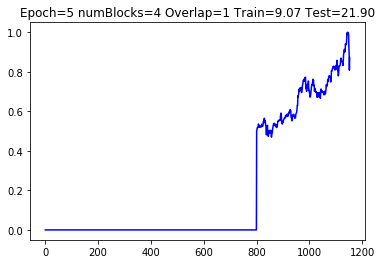

In [79]:
col = 0
testPlot = np.empty_like(trainSet)
testPlot[:, :] = 0
testPlot = np.vstack((testPlot, test))
testplot = scaler.inverse_transform(testPlot)
plt.plot(testPlot[:,col], color = 'blue')
plt.title('Epoch=%d numBlocks=%d Overlap=%d Train=%.2f Test=%.2f' % (epoch, numBlocks, overlap, trainScore, testScore))

In [80]:
testBand = np.array(testBand)
testBand = np.reshape(testBand, (testBand.shape))

In [81]:
testBand.shape

(24, 349, 2)

In [82]:
print(np.mean(testBand[:,0,:], axis = 0))
print(np.std(testBand[:,0,:], axis = 0))

[790.10376 789.4321 ]
[31.392834 26.561451]


In [83]:
z_alpha = 1.96
n = factorial(numBlocks)

confInterval = []

# Calculate the 95% confidence interval for each time step
for i in range(testBand.shape[1]):
    X = testBand[:, i, :]
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

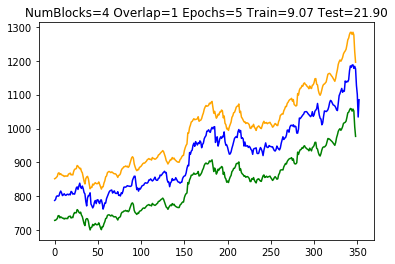

In [90]:
col = 0
offset = len(trainPredict)+(lookBack*2)+2
lower = []
upper = []

# Get upper and lower bounds
for i in range(len(confInterval)):
    lower.append(confInterval[i][0][0])
    upper.append(confInterval[i][1][0])

# XLower = np.array(range(offset+1, offset+1+testBand.shape[1]))
# XUpper = np.array(range(offset+1, offset+1+testBand.shape[1]))
# plt.plot(XLower, lower)
# plt.plot(XUpper, upper)
plt.plot(lower, color = 'green')
plt.plot(upper, color = 'orange')
plt.plot(scaler.inverse_transform(test)[:, col], color = 'blue')
plt.title('NumBlocks=%d Overlap=%d Epochs=%d Train=%.2f Test=%.2f' % (numBlocks, overlap, epoch, trainScore, testScore))
plt.savefig("./Plots/ResampledBlockBootstrap/"+str(numBlocks)+"_"+str(overlap)+"_"+str(epoch)+".png")
plt.show()

In [91]:
upper

[851.633716583252,
 853.0487251281738,
 855.6314849853516,
 858.4589614868164,
 867.5132446289062,
 869.1838760375977,
 863.7785682678223,
 866.2480278015137,
 863.7622108459473,
 861.3240852355957,
 861.2488975524902,
 858.2017707824707,
 860.2503280639648,
 858.9492645263672,
 859.9647407531738,
 859.2264060974121,
 865.5902633666992,
 866.122371673584,
 868.3923416137695,
 862.8842391967773,
 864.1422996520996,
 862.740650177002,
 873.4366912841797,
 879.3681335449219,
 880.515510559082,
 881.5150985717773,
 890.693473815918,
 888.6262435913086,
 884.6617813110352,
 881.2169723510742,
 882.5643692016602,
 873.4414749145508,
 868.9217910766602,
 856.6047630310059,
 844.2011985778809,
 836.228214263916,
 851.8877258300781,
 856.6072235107422,
 858.6664161682129,
 851.385570526123,
 835.4028701782227,
 822.0107345581055,
 826.0802345275879,
 826.0164375305176,
 835.744327545166,
 833.160888671875,
 837.2600975036621,
 839.9601020812988,
 837.1906585693359,
 837.0073051452637,
 837.4968

In [92]:
# Sum of the lengths of the confidence intervals at each time point.
sumIntervals = np.sum(abs(np.array(upper) - np.array(lower)))

In [93]:
sumIntervals

53888.8805847168

In [94]:
# Length of maximum interval
maxInterval = np.max(np.array(upper) - np.array(lower))

In [95]:
maxInterval

226.97511291503906